# Machine Learning

In [ ]:
from final_functions.final_ML import time_series_dataframe_ML
from final_functions.final_ML import make_dataframe
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [ ]:
df_ts_ML, _, _ = time_series_dataframe_ML()
df_ML = make_dataframe(60,10)
X = df_ML.iloc[:, :9].values
y = df_ML['label'].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, shuffle = True)

scaler_ML = MinMaxScaler()
#scaler_ML_test = MinMaxScaler()
X_train_scaled = scaler_ML.fit_transform(X_train)
x_test_scaled = scaler_ML.transform(X_test)

from sklearn.metrics import accuracy_score
RFC = RandomForestClassifier(n_estimators=50, max_depth = 30, random_state = 42, min_samples_leaf=8, min_samples_split=8)
RFC.fit(X_train_scaled, y_train)
RFC_predict = RFC.predict(x_test_scaled)
RFC_ac = accuracy_score(y_test, RFC_predict)
print("Random Forest Classifier Precition Accuracy : ", RFC_ac)

Random Forest Classifier Precition Accuracy :  0.9361510115063548


In [20]:
params = { 'n_estimators' : [10,20,50,100],
           'max_depth' : [10,20,30,40,50,60],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 42, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train_scaled, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

# Deep Learning - Transformer

In [6]:
import numpy as np
import torch
import random
from final_functions.final_transformer import *

# Hyper Parameter
input_window = 100
output_window = 60
epochs = 1000
batch_size = 512

# Dataset 불러오기
df_DL = time_series_dataframe()

In [7]:
from thesis.transformer import new_multistep_time_series
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()

df_DL_temp = df_DL['TEMP'].values
df_DL_label = df_DL['label'].values

train_len = int(len(df_DL) * 0.8)
train_data = df_DL_temp[:train_len]
test_data = df_DL_temp[train_len:]
train_label = df_DL_label[:train_len]
test_label = df_DL_label[train_len:]

scaled_train = scaler_train.fit_transform(train_data.reshape(-1,1)).reshape(-1)
scaled_test = scaler_test.fit_transform(test_data.reshape(-1,1)).reshape(-1)


train_data, _ = new_multistep_time_series(scaled_train, train_label, input_window, output_window)
test_data, test_label = new_multistep_time_series(scaled_test, test_label, input_window, output_window)

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# PyTorch 돌리기위한 설정
lr = 0.0001
device = 'cuda' if torch.cuda.is_available else 'cpu' 
model = TransAm().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

# train_dataset = TimeSeiresDataset(X_train, y_train, input_window)
# test_dataset = TimeSeiresDataset(X_test, y_test, input_window)
# train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
# test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
train_data = train_data.to(device)
test_data = test_data.to(device)

In [318]:
def plot_and_loss2(model, data_source, criterion,input_window, output_window, scaler_DL):
    model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    result_to_ML = []
    with torch.no_grad():
        for i in tqdm(range(len(data_source)-1)):
            data, target = get_batch(data_source, i,1, input_window)
            # look like the model returns static values for the output window
            output = model(data)
            if calculate_loss_over_all_values:
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()
            
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
            result_to_ML.append(output[-output_window:].view(-1).cpu().detach().numpy())
            
    test_result = scaler_DL.inverse_transform(test_result.reshape(-1,1)).reshape(-1)
    truth = scaler_DL.inverse_transform(truth.reshape(-1,1)).reshape(-1)
    
    plt.plot(test_result,label = 'Prediction')
    plt.plot(truth,label = 'Truth')
    #pyplot.plot(test_result-truth,color="green")
    plt.grid(True, which='both')
    plt.legend()
    plt.show()
    plt.close()
    
    return truth, test_result, result_to_ML, total_loss / i

| epoch   1 |   207/ 1035 batches | lr 0.000100 | 44.80 ms | loss 0.06603 | ppl     1.07 |
| epoch   1 |   414/ 1035 batches | lr 0.000100 | 44.60 ms | loss 0.00447 | ppl     1.00 |
| epoch   1 |   621/ 1035 batches | lr 0.000100 | 45.49 ms | loss 0.00265 | ppl     1.00 |
| epoch   1 |   828/ 1035 batches | lr 0.000100 | 44.77 ms | loss 0.00157 | ppl     1.00 |
| epoch   1 |  1035/ 1035 batches | lr 0.000100 | 44.75 ms | loss 0.00221 | ppl     1.00 |
------------------------------------------------------------------------------------------
| end of epoch   1 | time: 50.53s | valid loss 0.70525 | valid ppl     2.02 |
------------------------------------------------------------------------------------------
| epoch   2 |   207/ 1035 batches | lr 0.000096 | 45.00 ms | loss 0.04873 | ppl     1.05 |
| epoch   2 |   414/ 1035 batches | lr 0.000096 | 44.79 ms | loss 0.00189 | ppl     1.00 |
| epoch   2 |   621/ 1035 batches | lr 0.000096 | 44.79 ms | loss 0.00197 | ppl     1.00 |
| epoch   2 

  0%|          | 0/132481 [00:00<?, ?it/s]

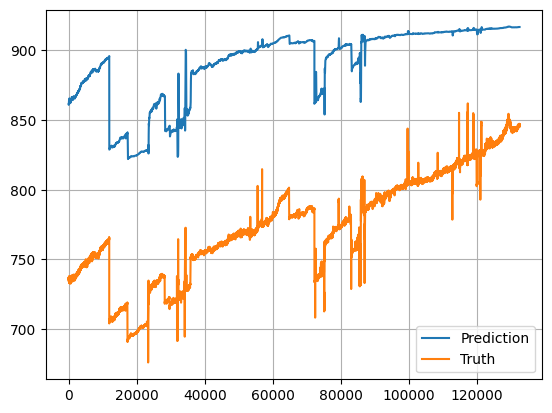

------------------------------------------------------------------------------------------
| end of epoch  20 | time: 119.66s | valid loss 0.40294 | valid ppl     1.50 |
------------------------------------------------------------------------------------------
| epoch  21 |   207/ 1035 batches | lr 0.000065 | 45.13 ms | loss 0.02584 | ppl     1.03 |
| epoch  21 |   414/ 1035 batches | lr 0.000065 | 45.63 ms | loss 0.00046 | ppl     1.00 |
| epoch  21 |   621/ 1035 batches | lr 0.000065 | 44.82 ms | loss 0.00061 | ppl     1.00 |
| epoch  21 |   828/ 1035 batches | lr 0.000065 | 44.81 ms | loss 0.00075 | ppl     1.00 |
| epoch  21 |  1035/ 1035 batches | lr 0.000065 | 44.81 ms | loss 0.00103 | ppl     1.00 |
------------------------------------------------------------------------------------------
| end of epoch  21 | time: 50.73s | valid loss 0.38890 | valid ppl     1.48 |
------------------------------------------------------------------------------------------
| epoch  22 |   207/ 103

  0%|          | 0/132481 [00:00<?, ?it/s]

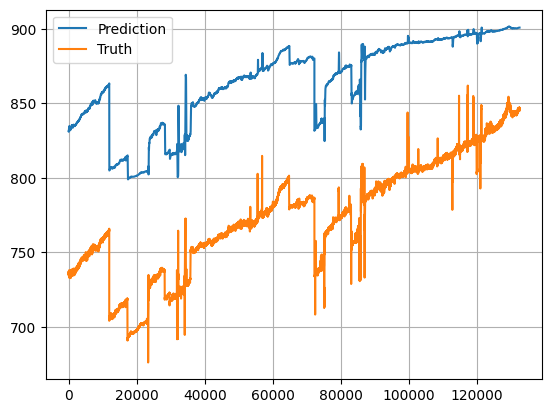

------------------------------------------------------------------------------------------
| end of epoch  40 | time: 117.69s | valid loss 0.24263 | valid ppl     1.27 |
------------------------------------------------------------------------------------------
| epoch  41 |   207/ 1035 batches | lr 0.000044 | 45.06 ms | loss 0.02747 | ppl     1.03 |
| epoch  41 |   414/ 1035 batches | lr 0.000044 | 44.71 ms | loss 0.00033 | ppl     1.00 |
| epoch  41 |   621/ 1035 batches | lr 0.000044 | 44.67 ms | loss 0.00045 | ppl     1.00 |
| epoch  41 |   828/ 1035 batches | lr 0.000044 | 44.70 ms | loss 0.00060 | ppl     1.00 |
| epoch  41 |  1035/ 1035 batches | lr 0.000044 | 44.71 ms | loss 0.00080 | ppl     1.00 |
------------------------------------------------------------------------------------------
| end of epoch  41 | time: 50.45s | valid loss 0.23581 | valid ppl     1.27 |
------------------------------------------------------------------------------------------
| epoch  42 |   207/ 103

  0%|          | 0/132481 [00:00<?, ?it/s]

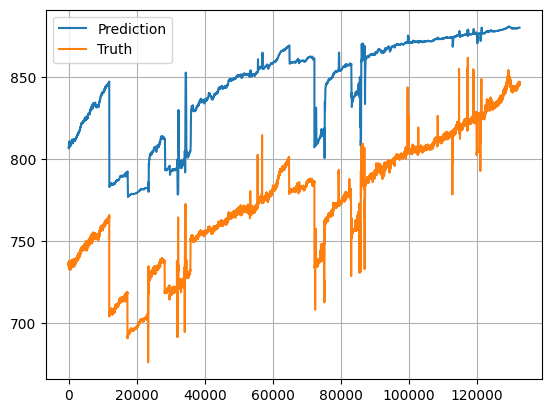

------------------------------------------------------------------------------------------
| end of epoch  60 | time: 134.88s | valid loss 0.15120 | valid ppl     1.16 |
------------------------------------------------------------------------------------------
| epoch  61 |   207/ 1035 batches | lr 0.000029 | 45.21 ms | loss 0.02471 | ppl     1.03 |
| epoch  61 |   414/ 1035 batches | lr 0.000029 | 44.88 ms | loss 0.00049 | ppl     1.00 |
| epoch  61 |   621/ 1035 batches | lr 0.000029 | 44.83 ms | loss 0.00045 | ppl     1.00 |
| epoch  61 |   828/ 1035 batches | lr 0.000029 | 44.78 ms | loss 0.00057 | ppl     1.00 |
| epoch  61 |  1035/ 1035 batches | lr 0.000029 | 44.79 ms | loss 0.00081 | ppl     1.00 |
------------------------------------------------------------------------------------------
| end of epoch  61 | time: 50.60s | valid loss 0.15142 | valid ppl     1.16 |
------------------------------------------------------------------------------------------
| epoch  62 |   207/ 103

  0%|          | 0/132481 [00:00<?, ?it/s]

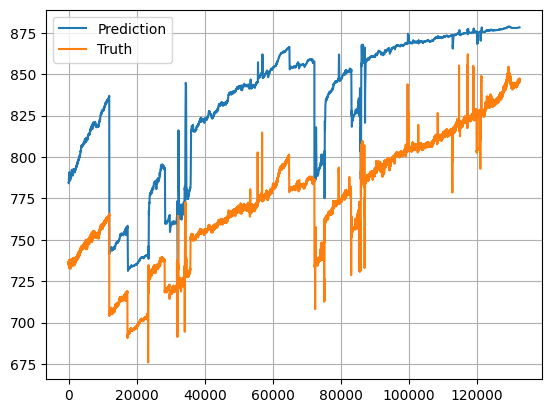

------------------------------------------------------------------------------------------
| end of epoch  80 | time: 168.66s | valid loss 0.10713 | valid ppl     1.11 |
------------------------------------------------------------------------------------------
| epoch  81 |   207/ 1035 batches | lr 0.000019 | 46.05 ms | loss 0.01048 | ppl     1.01 |
| epoch  81 |   414/ 1035 batches | lr 0.000019 | 44.89 ms | loss 0.00079 | ppl     1.00 |
| epoch  81 |   621/ 1035 batches | lr 0.000019 | 44.85 ms | loss 0.00040 | ppl     1.00 |
| epoch  81 |   828/ 1035 batches | lr 0.000019 | 44.81 ms | loss 0.00063 | ppl     1.00 |
| epoch  81 |  1035/ 1035 batches | lr 0.000019 | 44.82 ms | loss 0.00109 | ppl     1.00 |
------------------------------------------------------------------------------------------
| end of epoch  81 | time: 50.79s | valid loss 0.10328 | valid ppl     1.11 |
------------------------------------------------------------------------------------------
| epoch  82 |   207/ 103

  0%|          | 0/132481 [00:00<?, ?it/s]

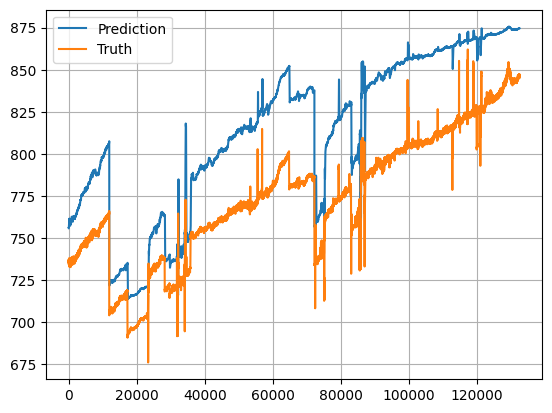

------------------------------------------------------------------------------------------
| end of epoch 100 | time: 114.25s | valid loss 0.04813 | valid ppl     1.05 |
------------------------------------------------------------------------------------------
| epoch 101 |   207/ 1035 batches | lr 0.000013 | 45.26 ms | loss 0.00728 | ppl     1.01 |
| epoch 101 |   414/ 1035 batches | lr 0.000013 | 44.96 ms | loss 0.00073 | ppl     1.00 |
| epoch 101 |   621/ 1035 batches | lr 0.000013 | 44.93 ms | loss 0.00062 | ppl     1.00 |
| epoch 101 |   828/ 1035 batches | lr 0.000013 | 44.91 ms | loss 0.00051 | ppl     1.00 |
| epoch 101 |  1035/ 1035 batches | lr 0.000013 | 44.91 ms | loss 0.00094 | ppl     1.00 |
------------------------------------------------------------------------------------------
| end of epoch 101 | time: 50.71s | valid loss 0.04667 | valid ppl     1.05 |
------------------------------------------------------------------------------------------
| epoch 102 |   207/ 103

  0%|          | 0/132481 [00:00<?, ?it/s]

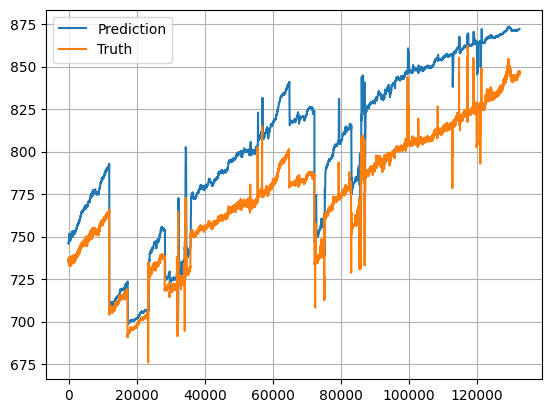

------------------------------------------------------------------------------------------
| end of epoch 120 | time: 123.97s | valid loss 0.02656 | valid ppl     1.03 |
------------------------------------------------------------------------------------------
| epoch 121 |   207/ 1035 batches | lr 0.000009 | 45.25 ms | loss 0.00460 | ppl     1.00 |
| epoch 121 |   414/ 1035 batches | lr 0.000009 | 44.93 ms | loss 0.00063 | ppl     1.00 |
| epoch 121 |   621/ 1035 batches | lr 0.000009 | 44.93 ms | loss 0.00066 | ppl     1.00 |
| epoch 121 |   828/ 1035 batches | lr 0.000009 | 44.95 ms | loss 0.00053 | ppl     1.00 |
| epoch 121 |  1035/ 1035 batches | lr 0.000009 | 44.93 ms | loss 0.00084 | ppl     1.00 |
------------------------------------------------------------------------------------------
| end of epoch 121 | time: 50.71s | valid loss 0.02578 | valid ppl     1.03 |
------------------------------------------------------------------------------------------
| epoch 122 |   207/ 103

  0%|          | 0/132481 [00:00<?, ?it/s]

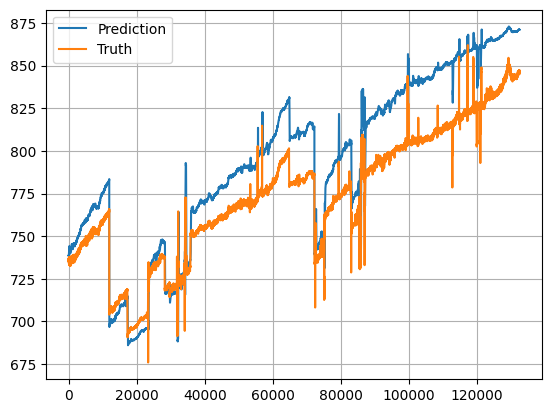

------------------------------------------------------------------------------------------
| end of epoch 140 | time: 128.90s | valid loss 0.01636 | valid ppl     1.02 |
------------------------------------------------------------------------------------------
| epoch 141 |   207/ 1035 batches | lr 0.000006 | 45.29 ms | loss 0.00298 | ppl     1.00 |
| epoch 141 |   414/ 1035 batches | lr 0.000006 | 45.00 ms | loss 0.00060 | ppl     1.00 |
| epoch 141 |   621/ 1035 batches | lr 0.000006 | 44.99 ms | loss 0.00065 | ppl     1.00 |
| epoch 141 |   828/ 1035 batches | lr 0.000006 | 44.99 ms | loss 0.00057 | ppl     1.00 |
| epoch 141 |  1035/ 1035 batches | lr 0.000006 | 44.97 ms | loss 0.00078 | ppl     1.00 |
------------------------------------------------------------------------------------------
| end of epoch 141 | time: 50.77s | valid loss 0.01594 | valid ppl     1.02 |
------------------------------------------------------------------------------------------
| epoch 142 |   207/ 103

  0%|          | 0/132481 [00:00<?, ?it/s]

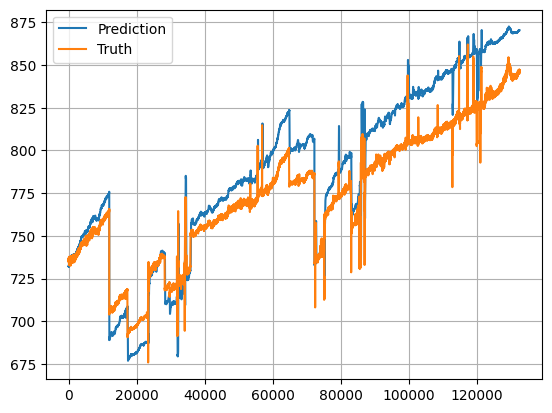

------------------------------------------------------------------------------------------
| end of epoch 160 | time: 130.30s | valid loss 0.01075 | valid ppl     1.01 |
------------------------------------------------------------------------------------------
| epoch 161 |   207/ 1035 batches | lr 0.000004 | 45.29 ms | loss 0.00211 | ppl     1.00 |
| epoch 161 |   414/ 1035 batches | lr 0.000004 | 44.99 ms | loss 0.00059 | ppl     1.00 |
| epoch 161 |   621/ 1035 batches | lr 0.000004 | 44.94 ms | loss 0.00063 | ppl     1.00 |
| epoch 161 |   828/ 1035 batches | lr 0.000004 | 44.99 ms | loss 0.00060 | ppl     1.00 |
| epoch 161 |  1035/ 1035 batches | lr 0.000004 | 44.96 ms | loss 0.00074 | ppl     1.00 |
------------------------------------------------------------------------------------------
| end of epoch 161 | time: 50.75s | valid loss 0.01052 | valid ppl     1.01 |
------------------------------------------------------------------------------------------
| epoch 162 |   207/ 103

  0%|          | 0/132481 [00:00<?, ?it/s]

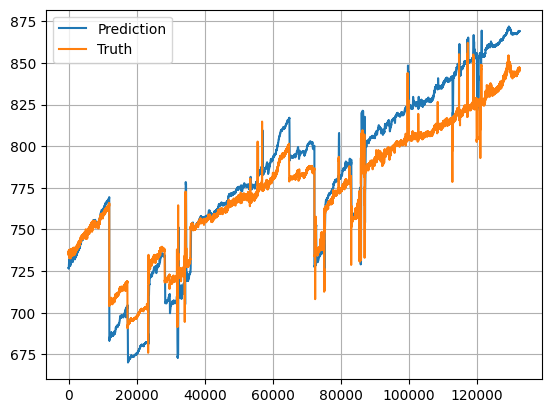

------------------------------------------------------------------------------------------
| end of epoch 180 | time: 124.74s | valid loss 0.00750 | valid ppl     1.01 |
------------------------------------------------------------------------------------------
| epoch 181 |   207/ 1035 batches | lr 0.000003 | 45.40 ms | loss 0.00162 | ppl     1.00 |
| epoch 181 |   414/ 1035 batches | lr 0.000003 | 45.06 ms | loss 0.00057 | ppl     1.00 |
| epoch 181 |   621/ 1035 batches | lr 0.000003 | 45.05 ms | loss 0.00063 | ppl     1.00 |
| epoch 181 |   828/ 1035 batches | lr 0.000003 | 45.07 ms | loss 0.00063 | ppl     1.00 |
| epoch 181 |  1035/ 1035 batches | lr 0.000003 | 45.08 ms | loss 0.00073 | ppl     1.00 |
------------------------------------------------------------------------------------------
| end of epoch 181 | time: 50.85s | valid loss 0.00738 | valid ppl     1.01 |
------------------------------------------------------------------------------------------
| epoch 182 |   207/ 103

KeyboardInterrupt: 

In [319]:
best_val_loss = float("inf")
best_model = None

for epoch in range(1, epochs + 1):
    start_time = time.time()
    train_tmp(model, train_data,batch_size, optimizer, criterion, input_window, output_window, epoch, scheduler)
    
    if (epoch % 20 == 0):
        truth, test_result, result_to_ML, val_loss = plot_and_loss2(model, test_data, criterion,input_window, output_window, scaler_test)
    else:
        val_loss = evaluate2(model, test_data, criterion, output_window, input_window)
    
    print('-' * 90)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f} |'.format(epoch, (time.time() - start_time),
                                        val_loss, math.exp(val_loss)))
    print('-' * 90)
    
    scheduler.step()
    

PATH = "./weights/"
torch.save(model, PATH + 'model.pt')
torch.save(model.state_dict(), PATH + 'model_state_dict.pt')

In [2]:
PATH = "./weights/"
torch.save(model, PATH + 'model.pt')
torch.save(model.state_dict(), PATH + 'model_state_dict.pt')

NameError: name 'model' is not defined

# Inference

In [3]:
import torch
model = torch.load(PATH + 'model.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
model.load_state_dict(torch.load(PATH + 'model_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장

<All keys matched successfully>

In [16]:
DataFrame = {'MEAN_TEMP' : [], 'STD' : [], 'MIN' : [], 'MAX' : [], 'SKEW' : [], 'KURT' : [], 'MEDIAN':[], '25%' : [], '75%' : [], 'label' : []}

def DF_to_DataFrame(data):
    mean = np.round(np.mean(data), 3)
    min = np.min(data)
    max = np.max(data)
    std = np.std(data)
    median = data.median()
    sk = data.skew()
    kurt = data.kurt()
    a, b = np.percentile(data, q = [25,75])
    
    return mean, min, max, std, median, sk, kurt, a, b

test_input = test_data[:, 0, :]
test_input = test_input.unsqueeze(1)
test_input = test_input.transpose(0, 2)
test_input.shape

def test_batch(data, index):
    data = data[:, :, index].unsqueeze(2)
    return data


model.eval()
with torch.no_grad():
    for i in tqdm(range(len(test_data))):
        data = test_batch(test_input, i)
        output = model(data)
        
        output = output[-60:].detach().cpu()
        output = scaler_test.inverse_transform(output.reshape(-1,1)).reshape(-1)
        output = list(output)
        output = pd.DataFrame({'TEMP' : output})
        A = output['TEMP']
        mean, min, max, std, median, skew, kurt, a, b, = DF_to_DataFrame(A)
        DataFrame['label'].append(math.ceil(test_label[i]/2))
        DataFrame['MEAN_TEMP'].append(mean)
        DataFrame['MIN'].append(min)
        DataFrame['MAX'].append(max)
        DataFrame['STD'].append(std)
        DataFrame['SKEW'].append(skew)
        DataFrame['KURT'].append(kurt)
        DataFrame['MEDIAN'].append(np.round(median,3))
        DataFrame['25%'].append(np.round(a,3))
        DataFrame['75%'].append(np.round(b,3))
    
DF = pd.DataFrame(DataFrame)
DF

  0%|          | 0/132482 [00:00<?, ?it/s]

,MEAN_TEMP,STD,MIN,MAX,SKEW,KURT,MEDIAN,25%,75%,label
0,731.099,72.375402,581.474159,903.638955,0.262936,-0.122287,729.271,685.402,771.898,5
1,731.097,72.376255,581.468093,903.632567,0.262868,-0.122478,729.273,685.403,771.903,5
2,731.092,72.377018,581.453499,903.625514,0.262749,-0.122576,729.271,685.401,771.912,5
3,731.088,72.375970,581.444860,903.614957,0.262615,-0.122622,729.273,685.394,771.915,5
4,731.086,72.372293,581.449529,903.603379,0.262520,-0.122642,729.275,685.391,771.912,5
...,...,...,...,...,...,...,...,...,...,...
132477,721.006,61.252756,596.115175,868.193832,0.346999,-0.084959,715.405,685.009,755.098,6
132478,721.000,61.250912,596.112541,868.183275,0.346991,-0.084962,715.395,685.004,755.088,6
132479,720.995,61.248969,596.109974,868.172983,0.346942,-0.084948,715.393,685.001,755.082,6
132480,720.992,61.246292,596.108754,868.161894,0.346846,-0.084946,715.394,684.999,755.080,6


In [17]:
DF[DF['label'] == 5]

,MEAN_TEMP,STD,MIN,MAX,SKEW,KURT,MEDIAN,25%,75%,label
0,731.099,72.375402,581.474159,903.638955,0.262936,-0.122287,729.271,685.402,771.898,5
1,731.097,72.376255,581.468093,903.632567,0.262868,-0.122478,729.273,685.403,771.903,5
2,731.092,72.377018,581.453499,903.625514,0.262749,-0.122576,729.271,685.401,771.912,5
3,731.088,72.375970,581.444860,903.614957,0.262615,-0.122622,729.273,685.394,771.915,5
4,731.086,72.372293,581.449529,903.603379,0.262520,-0.122642,729.275,685.391,771.912,5
...,...,...,...,...,...,...,...,...,...,...
72201,726.114,67.274449,587.497381,886.787559,0.294336,-0.105965,722.269,685.665,763.525,5
72202,726.114,67.274328,587.496743,886.786805,0.294344,-0.105945,722.268,685.664,763.524,5
72203,726.113,67.274251,587.496022,886.786051,0.294348,-0.105930,722.267,685.664,763.524,5
72204,726.112,67.274084,587.495257,886.785119,0.294347,-0.105927,722.267,685.664,763.524,5


In [18]:
transformer_X = DF.iloc[:, :9].values
transformer_y = DF['label'].values

transformer_X
transformer_scaled = scaler_ML.transform(transformer_X)

array([[731.099     ,  72.37540164, 581.47415929, ..., 729.271     ,
        685.402     , 771.898     ],
       [731.097     ,  72.37625546, 581.4680932 , ..., 729.273     ,
        685.403     , 771.903     ],
       [731.092     ,  72.3770182 , 581.4534991 , ..., 729.271     ,
        685.401     , 771.912     ],
       ...,
       [720.995     ,  61.24896937, 596.10997407, ..., 715.393     ,
        685.001     , 755.082     ],
       [720.992     ,  61.24629247, 596.1087542 , ..., 715.394     ,
        684.999     , 755.08      ],
       [720.99      ,  61.24261097, 596.11022359, ..., 715.396     ,
        685.001     , 755.074     ]])

In [10]:
transformer_predict = RFC.predict(transformer_scaled)
transformer_ac = accuracy_score(transformer_predict, transformer_y)
transformer_ac

NameError: name 'RFC' is not defined